In [1]:
import pypandoc

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('GIP_EUR_DataSet.xlsx')
scaler = StandardScaler()
df_scaled = scaler.fit(df)
df_scaled = scaler.transform(df)


In [4]:
df

,GIP (BCFperSection),EURper1000ft
0,49.5,1.710526
1,49.5,3.552632
2,52.8,0.263158
3,52.8,3.377193
4,56.1,1.754386
...,...,...
195,396.0,3.464912
196,415.8,1.228070
197,415.8,3.245614
198,452.1,0.789474


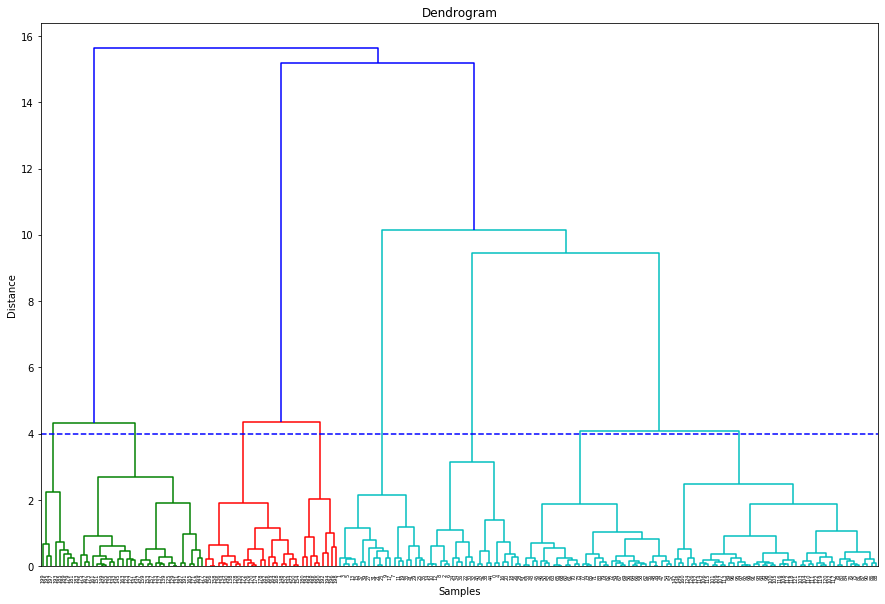

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
dend = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Dendrogram') 
plt.axhline(y=4, color='b', linestyle='--')

In [6]:
hc = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
hc=hc.fit_predict(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns = df.columns[0:2])
df_scaled['Cluster'] = hc

Text(0.5, 0, 'silhouette coefficient')

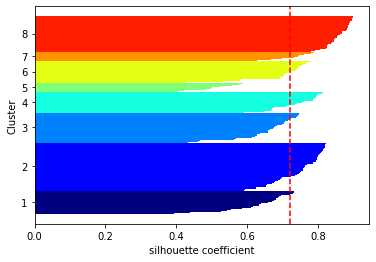

In [7]:
from sklearn.metrics import silhouette_samples

cluster_labels=np.unique(hc)
n_clusters=cluster_labels.shape[0]
silhouette_vals=silhouette_samples(df_scaled,hc,metric='euclidean')
y_ax_lower, y_ax_upper=0,0
yticks=[]
for i, c in enumerate (cluster_labels):
    c_silhouette_vals= silhouette_vals[hc==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color= plt.cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,height=1,edgecolor='none',color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg=np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')

In [8]:
df_scaled['GIP (BCFperSection)']=(df_scaled['GIP (BCFperSection)']*(df['GIP (BCFperSection)'].std())+df['GIP (BCFperSection)'].mean())
df_scaled['EURper1000ft']=(df_scaled['EURper1000ft']*(df['EURper1000ft'].std())+df['EURper1000ft'].mean())

In [9]:
df_scaled

,GIP (BCFperSection),EURper1000ft,Cluster
0,49.122715,1.709294,0
1,49.122715,3.556021,3
2,52.430996,0.258293,0
3,52.430996,3.380143,3
4,55.739277,1.753263,0
...,...,...,...
195,396.492227,3.468082,6
196,416.341913,1.225627,4
197,416.341913,3.248234,6
198,452.733005,0.785930,4


In [10]:
df_scaled.to_csv('hc-ac.csv')

In [11]:
df1=pd.read_csv('PE_Income_Spending_DataSet.csv')
df1 = pd.get_dummies(df1,drop_first=True)
df1

,Petroleum_Engineer_Age,Petroleum_Engineer_Income (K$),Spending_Habits (From 1 to 100),Petroleum_Engineer_Gender_Male
0,19,34.676354,37.05,1
1,21,34.676354,76.95,1
2,20,36.988111,5.70,0
3,23,36.988111,73.15,0
4,31,39.299868,38.00,0
...,...,...,...,...
195,35,277.410832,75.05,0
196,45,291.281374,26.60,0
197,32,291.281374,70.30,1
198,32,316.710700,17.10,1


In [12]:
from sklearn.ensemble import IsolationForest


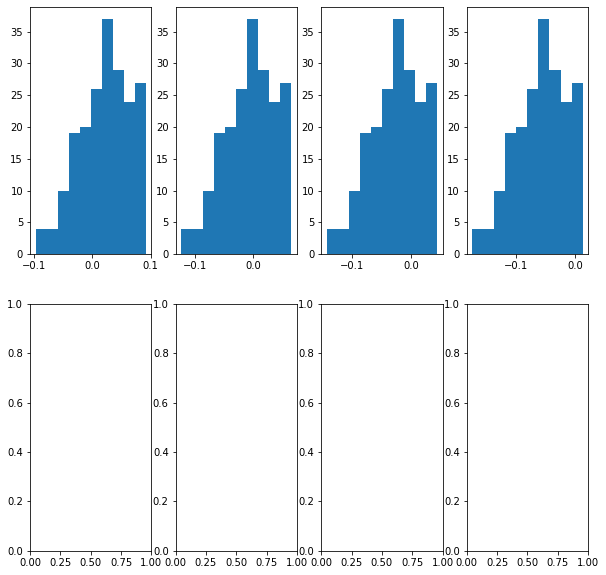

In [13]:
contaminations = [0.3,0.5, 0.7, 0.9]
fig1,ax1 = plt.subplots(2,4,figsize=(10,10))
names=[]
names1 = []
for i,x in enumerate(contaminations):
    clf = IsolationForest(n_estimators=100,max_samples=200,random_state=100, contamination=x) 
    clf.fit(df1)
    name  = 'scores_' + str(x)
    df1[name]=clf.decision_function(df1)
    ax1[0,i].hist(df1[name])
    names.append(name)
    df1.drop(axis=1,labels=name,inplace=True)
    


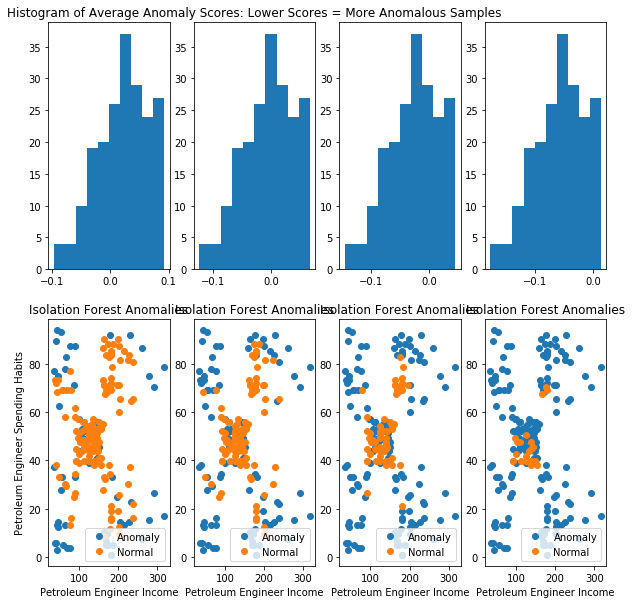

In [14]:
contaminations = [0.3,0.5, 0.7, 0.9]
fig1,ax1 = plt.subplots(2,4,figsize=(10,10))
for idx, x in enumerate(contaminations):
    
    clf = IsolationForest(n_estimators=100,max_samples=200,random_state=100, contamination=x) 
    clf.fit(df1)
    
    df1['scores']=clf.decision_function(df1)
    
    ax1[0,idx].hist(df1['scores'])
    ax1[0,1].set_title('Histogram of Average Anomaly Scores: Lower Scores = More Anomalous Samples')
    
    df1['Anomaly']=clf.predict(df1.iloc[:,:4])
    groups = df1.groupby("Anomaly")
    for name, group in groups:
        ax1[1,idx].plot(group['Petroleum_Engineer_Income (K$)'], group['Spending_Habits (From 1 to 100)'], marker="o", linestyle="", label=name)
    ax1[1,idx].set_xlabel('Petroleum Engineer Income')
    ax1[1,0].set_ylabel('Petroleum Engineer Spending Habits')
    ax1[1,idx].set_title('Isolation Forest Anomalies') 
    ax1[1,idx].legend(labels=['Anomaly','Normal'])
    df1.drop(axis=1,labels=['scores','Anomaly'],inplace=True)


In [15]:
pypandoc.convert_file('Assignment8.md','docx',outputfile='Assignment8.docx')

''